In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from glob import glob
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
import time

from collections import Sequence
# %matplotlib inline
import cv2

import os.path as osp
import matplotlib.cm as cm

import torchvision
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.utils import make_grid
from torch.utils.data import Dataset
from torch.nn import functional as F

/var/folders/j8/287qv_h962sgjzzwzh6whkpm0000gn/T/ipykernel_11141/953260573.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Sequence


In [2]:
from art.attacks.inference import model_inversion
from art.estimators.classification import PyTorchClassifier
from art.utils import load_cifar10

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
batch_size = 32
learning_rate = 0.001
num_epochs = 5

In [5]:
# Step 1: Load the cifar10 dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_cifar10()
print(x_train.shape)
print(min_pixel_value)
print(max_pixel_value)

(50000, 32, 32, 3)
0.0
1.0


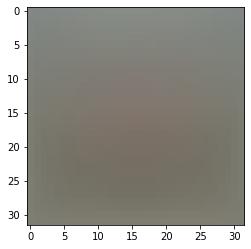

In [6]:
plt.imshow(np.mean(x_train, axis=0))

In [7]:
# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)
print(x_train.shape,x_test.shape)

(50000, 3, 32, 32) (10000, 3, 32, 32)


In [8]:
device = torch.device('mps')
num_classes = 10

# resnet = torchvision.models.resnet18(pretrained=True)
# resnet.fc = nn.Linear(512,num_classes)
# resnet.to(device)

vgg11 = torch.load("/Users/songjunzhe/Desktop/python/ml_attack/myvgg11_cifar10_test_82_0300.pt")
vgg11.classifier.add_module("7", nn.Softmax(dim=1))
vgg11.eval()
vgg11.to(device)
print(vgg11)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg11.parameters(), lr=0.01, weight_decay=5e-3, momentum=0.9)

# step_lr_schedular = lr_scheduler.StepLR(optimizer, step_size = 4, gamma = 0.5)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [9]:
classifier = PyTorchClassifier(
    model = vgg11,
    clip_values = (min_pixel_value,max_pixel_value),
    loss = criterion,
    optimizer = optimizer,
    input_shape = (3, 32, 32),
    nb_classes = 10,
)

In [10]:
#classifier.fit(x_train, y_train, batch_size=256, nb_epochs=5)

In [11]:
# Step 5: Create the attack object

my_attack = model_inversion.MIFace(classifier, max_iter=20000, threshold=1.)

In [12]:
# Step 6: Create an array of the classes to be attacked

# y_all = np.arange(10)
# y_all
y_all = np.array([0])
y_all

array([0])

In [13]:
# We will experiment with a number of different initializations:

# x_init_average = np.zeros((10, 3, 32, 32),dtype=np.float32) + np.mean(x_train, axis=0)
x_init_average = np.zeros((1, 3, 32, 32), dtype=np.float32) + np.mean(x_train, axis=0)


In [14]:
class_gradient = classifier.class_gradient(x_init_average, y_all)
# class_gradient = np.reshape(class_gradient, (30, 32*32))
class_gradient = np.reshape(class_gradient, (3, 32*32))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

Minimum over all maximum class gradient: 0.002144


In [15]:
inferred_images = my_attack.infer(x=x_init_average, y=y_all)

Model inversion:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
print(inferred_images.shape)
print(type(inferred_images))

(1, 3, 32, 32)
<class 'numpy.ndarray'>


In [17]:
# plot the inverted class representations
# num_row = 2
# num_col = 5
# fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
# for i in range(10):
#     ax = axes[i//num_col, i%num_col]
#     ax.set_axis_off()
#     ax.imshow(inferred_images[i,:,:,:].reshape(32,32,3))
#     ax.set_title('Label: {}'.format(y_all[i]))

# plt.tight_layout()
# plt.savefig("/Users/songjunzhe/Desktop/python/ml_attack/celeba_result/myvgg11_miface_iter={}.png".format(500))
# plt.show()

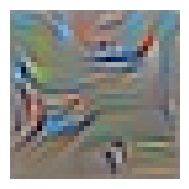

In [18]:
plt.figure(figsize=(2.24, 2.24),dpi=100,frameon=False)
plt.axis('off')
img = plt.imshow(inferred_images[0].transpose(1,2,0))
plt.savefig("/Users/songjunzhe/Desktop/python/ml_attack/celeba_result/myvgg11_miface_iter={},label=0.png".format(20000))
plt.show()